In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D
from learning3d.data_utils import ModelNet40Data  # ModelNet40 dataset kodunun olduğu dosyayı içe aktar
from torch import nn
from learning3d.models import PPFNet
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PointNetPPDecoder(nn.Module):
    def __init__(self, embedding_dim=128, num_points=1024):
        super(PointNetPPDecoder, self).__init__()
        self.num_points = num_points

        # Katmanlar: Boyutları kademeli artır
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_points * 3)
        )
    
    def forward(self, embedding):
        x = self.fc_layers(embedding)  # (B, num_points * 3)
        recon = x.view(-1, self.num_points, 3)  # (B, num_points, 3)
        return recon

In [4]:
encoder = PPFNet(features=['ppf', 'dxyz', 'xyz'], emb_dims=128, radius=0.3, num_neighbors=64).to(device)
decoder = PointNetPPDecoder(embedding_dim=128, num_points=1024).to(device)

In [5]:
ENCODER_PATH = "ppfnet128_encoder.pth"  # Kaydedilen encoder modelinin yolu
DECODER_PATH = "ppfnet128_decoder.pth"  # Kaydedilen decoder modelinin yolu

In [6]:
encoder.load_state_dict(torch.load(ENCODER_PATH, map_location=device))
decoder.load_state_dict(torch.load(DECODER_PATH, map_location=device))

encoder.eval()
decoder.eval()

PointNetPPDecoder(
  (fc_layers): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=3072, bias=True)
  )
)

In [7]:
# Dataset ve DataLoader oluştur
train_dataset = ModelNet40Data(train=True, num_points=1024)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

In [8]:
def compute_normals_single(points_single):
    """
    Tek bir nokta bulutu (N, 3) için Open3D kullanarak yüzey normallerini hesaplar.
    """
    pcd = o3d.geometry.PointCloud()
    # Noktaların numpy array'inin tipini float64'e dönüştürüyoruz
    pcd.points = o3d.utility.Vector3dVector(points_single.astype(np.float64))
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    normals = np.asarray(pcd.normals)
    return normals

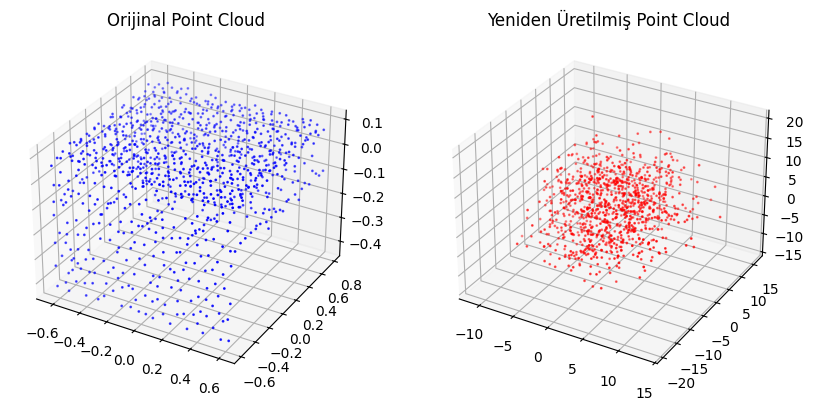

<Figure size 640x480 with 0 Axes>

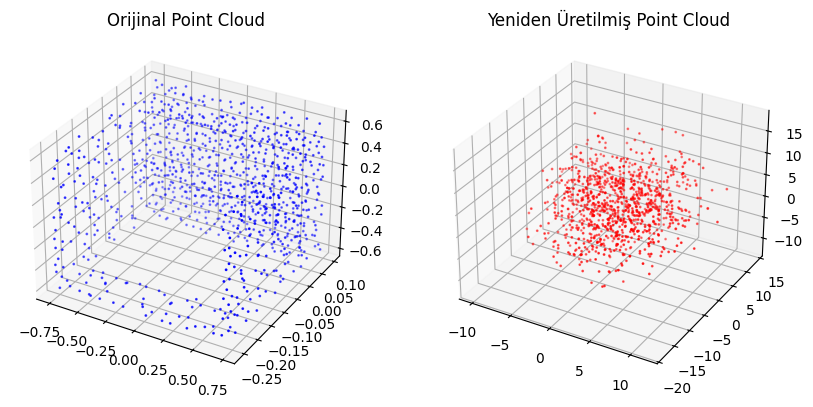

<Figure size 640x480 with 0 Axes>

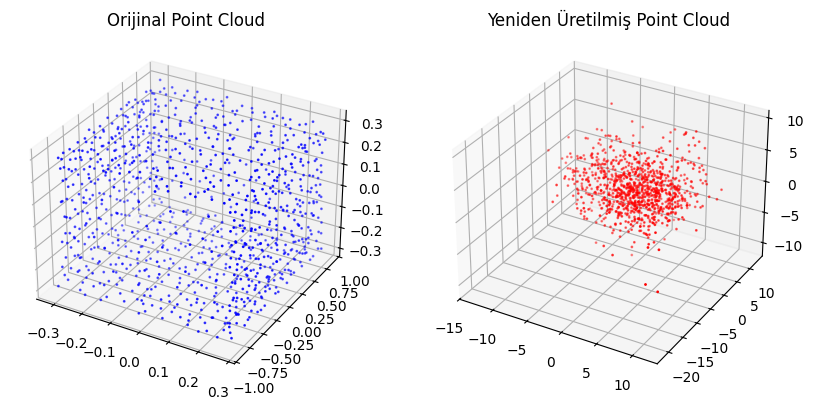

<Figure size 640x480 with 0 Axes>

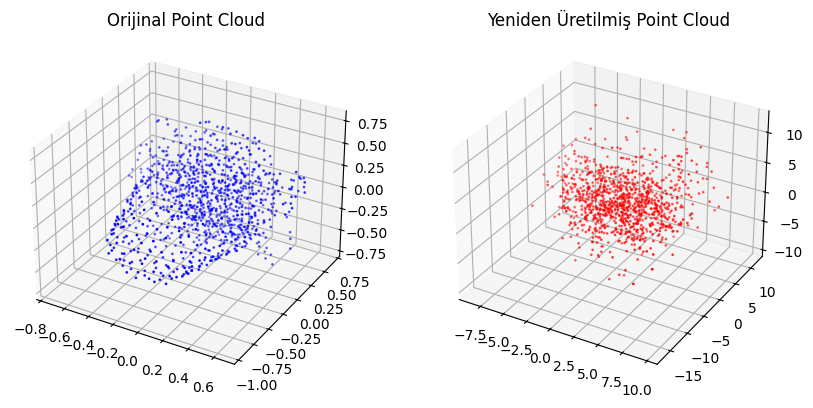

<Figure size 640x480 with 0 Axes>

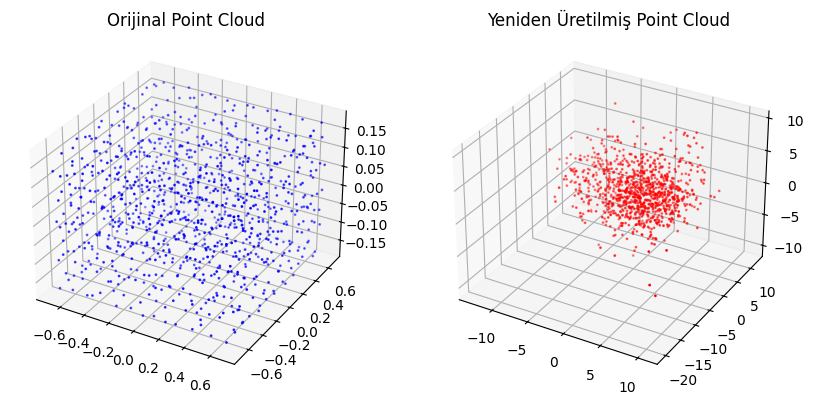

<Figure size 640x480 with 0 Axes>

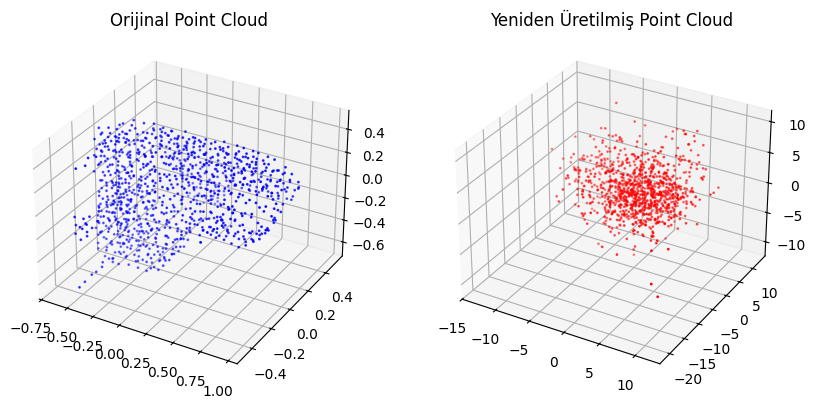

<Figure size 640x480 with 0 Axes>

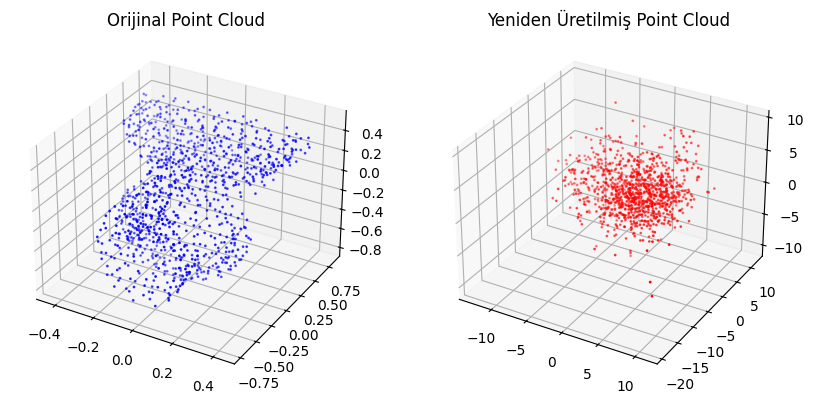

<Figure size 640x480 with 0 Axes>

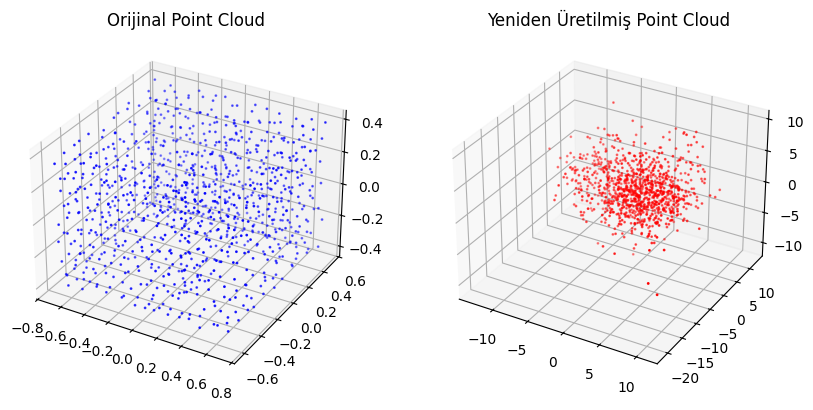

<Figure size 640x480 with 0 Axes>

In [9]:
for n in range(8):
    # Bir batch al
    data_iter = iter(train_loader)
    points, _ = next(data_iter)  # (B, N, 3) formatında gelir
    
    points = points - points.mean(dim=1, keepdim=True)  # Merkezi sıfıra getir
    points = points / torch.max(torch.norm(points, dim=-1, keepdim=True))  # Birime normalize et
            
    points = points.to(device, dtype=torch.float32)
            
    # Batch içindeki her örnek için normalleri hesaplayın.
    points_np = points.cpu().numpy()  # Şekil: (B, N, 3)
    normals_list = []
    for pc in points_np:
        normals_pc = compute_normals_single(pc)  # Her pc: (N, 3)
        normals_list.append(normals_pc)
    normals_np = np.stack(normals_list, axis=0)  # (B, N, 3)
    normals = torch.tensor(normals_np, dtype=torch.float32).to(device)
    
    points = points.to(device)
    
    # **1. Encoding** → Latent vektörü üret
    with torch.no_grad():
        latent_vectors = encoder(points, normals)  # (B, embedding_dim)
    
    # **2. Decoding** → Latent vektörden point cloud üret
    with torch.no_grad():
        reconstructed_points = decoder(latent_vectors)  # (B, N, 3)
    
    # **3. İlk batch'teki ilk noktayı seçip karşılaştır**
    original = points[0].cpu().numpy()
    reconstructed = reconstructed_points[0].cpu().numpy()
    
    # **4. Görselleştirme**
    fig = plt.figure(figsize=(10, 5))
    
    # Orijinal Nokta Bulutu
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(original[:, 0], original[:, 1], original[:, 2], c='b', marker='o', s=1)
    ax1.set_title("Orijinal Point Cloud")
    
    # Yeniden Üretilmiş Nokta Bulutu
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], c='r', marker='o', s=1)
    ax2.set_title("Yeniden Üretilmiş Point Cloud")
    
    plt.show()
    n += 1
    plt.savefig(fname = f"ppfnet128_{n}")